# HW 2 - Maci Simmons

In [1]:
import os
import os.path
import time
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import cvxpy as cp

tf.keras.utils.set_random_seed(42)

In [2]:
images_path = 'images/'

data_path = 'data/01_part_1/'

#tf.keras.preprocessing.image.load_img(os.path.join(images_path, ''))

## Data Setup

**Features Data:**  

Contains data related to the store, department, and regional activity for the given dates, such as:  
- store number  
- the week   
- average temperature in the region  
- cost of fuel in the region  
- five anonymous variables (called MarkDown 1, 2, 3, 4, 5) related to promotional markdowns that Walmart is running  
    - MarkDown data is not available for all stores at all times  
- the consumer price index (CPI)  
- the unemployment rate  
- a binary variable that indicates whether the week is a special holiday or not  


the four holidays (Super Bowl, Labor Day, Thanksgiving, Christmas), fall within the following weeks in the data  
not all holidays are in the data, and dates are in the form: dd-mm-yy  
**Super Bowl**: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13  
**Labor Day**: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13  
**Thanksgiving**: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13  
**Christmas**: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [3]:
features_data = pd.read_csv(os.path.join(data_path, 'features.csv'))

**Stores Data:**  

Contains anonymized information about the 45 stores.  
These variables indicate the type of store and the size of the store.

In [4]:
stores_data = pd.read_csv(os.path.join(data_path, 'stores.csv'))

**Train data:**  
Contains the labels for the training data.  
Covers 2010-02-05 to 2012-11-01.  
It includes the store number, the department number, and the date (week).  
Weekly sales for the given department in the given store.  
It also includes whether the week is a special holiday or not.

In [5]:
train_data = pd.read_csv(os.path.join(data_path, 'train.csv'))

In [6]:
data = pd.merge(features_data, stores_data, on=["Store"], how="outer")

data = pd.merge(data, train_data, on=["Store", "Date", "IsHoliday"], how="inner")

data

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1,24924.50
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2,50605.27
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,3,13740.12
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,4,39954.04
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,32229.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,93,2487.80
421566,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,94,5203.31
421567,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,95,56017.47
421568,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,97,6817.48


In [7]:
# Converting date column to datetime values and setting it as the index, then sorting it.
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

In [8]:
# An approximate 70/30 Time Series Split

training_data = data.loc[:'2011', :].copy()

testing_data = data.loc['2012':, :].copy()

In [9]:
# We can probably safely fill all missing values with zero.
# For the markdowns this means that there was no markdown.

training_data.fillna(0, inplace=True)
testing_data.fillna(0, inplace=True)

In [10]:
# We will only keep rows where we have nonnegative weekly sales, as this is a data error

training_data = training_data[training_data['Weekly_Sales']>=0]

testing_data = testing_data[testing_data['Weekly_Sales']>=0]

In [11]:
training_data['IsHoliday'] = np.where(training_data['IsHoliday'], 1, 0)
testing_data['IsHoliday'] = np.where(testing_data['IsHoliday'], 1, 0)

In [12]:
# Make sure we can later recognize what a dummy once belonged to

training_testing_data = [training_data, testing_data]

for df in training_testing_data:
  df['Type'] = 'Type_' + df['Type'].map(str)
  df['Store'] = 'Store_' + df['Store'].map(str)
  df['Dept'] = 'Dept_' + df['Dept'].map(str)
  df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

  df['Month'] = 'Month_' + df.index.month.map(str)

  df['Black_Friday'] = np.where((df.index==datetime(2010, 11, 26).date()) | (df.index==datetime(2011, 11, 25).date()), 'yes', 'no')
  df['Pre_Christmas'] = np.where((df.index==datetime(2010, 12, 23).date()) | (df.index==datetime(2010, 12, 24).date()) | (df.index==datetime(2011, 12, 23).date()) | (df.index==datetime(2011, 12, 24).date()), 'yes', 'no')
  df['Black_Friday'] = 'Black_Friday_' + df['Black_Friday'].map(str)
  df['Pre_Christmas'] = 'Pre_Christmas_' + df['Pre_Christmas'].map(str)

In [13]:
# Create dummies for store features and for holiday indicator

for df, i in zip(training_testing_data, range(2)):
  type_dummies = pd.get_dummies(df['Type'], drop_first=True).astype(int)
  store_dummies = pd.get_dummies(df['Store'], drop_first=True).astype(int)
  dept_dummies = pd.get_dummies(df['Dept'], drop_first=True).astype(int)
  holiday_dummies = pd.get_dummies(df['IsHoliday'], drop_first=True).astype(int)

  month_dummies = pd.get_dummies(df['Month'], drop_first=True).astype(int)

  Black_Friday_dummies = pd.get_dummies(df['Black_Friday'], drop_first=True).astype(int)
  Pre_christmas_dummies = pd.get_dummies(df['Pre_Christmas'], drop_first=True).astype(int)

  if i == 1:
    # Nov, Dec are not in the testing sample, so we must add the columns manually
    df['Month_11'] = 0
    df['Month_12'] = 0

  training_testing_data[i] = pd.concat([df,
                                        type_dummies, store_dummies, dept_dummies, holiday_dummies,
                                        month_dummies,
                                        Black_Friday_dummies, Pre_christmas_dummies],
                                        axis=1)

In [14]:
training_data = training_testing_data[0]

testing_data = training_testing_data[1]

In [15]:
# Normalize the numerical variables using means and stds from the TRAINING DATA
for df in training_testing_data:
  df[['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = (df[['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] - training_testing_data[0][['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean())/(training_testing_data[0][['Unemployment', 'Temperature', 'Fuel_Price', 'CPI', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].std())

In [16]:
# Let's separate our data into X and Y

X_train = training_data[training_data.columns.drop('Weekly_Sales')].select_dtypes(include=np.number)
Y_train = training_data[['Weekly_Sales']]

X_test = testing_data[testing_data.columns.drop('Weekly_Sales')].select_dtypes(include=np.number)
Y_test = testing_data[['Weekly_Sales']]

In [17]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((293259, 148), (127026, 148), (293259, 1), (127026, 1))

In [19]:
X_test = X_test[X_train.columns]
scaler = StandardScaler()

In [20]:
# Fit the scaler to the training data and transform the training data
x_train_norm = scaler.fit_transform(X_train)

# Transform the test data with the same scaler
x_test_norm = scaler.transform(X_test)

In [21]:
y_scaler = StandardScaler()

In [22]:
# Fit the scaler to the training data and transform the training data
y_train_norm = y_scaler.fit_transform(Y_train)

# Transform the test data with the same scaler
y_test_norm = y_scaler.transform(Y_test)

In [29]:
x_train_norm.shape

(293259, 148)

## Question 1: Tweaking Parameters in PCA

In [23]:
# Consider the following list of number of components - 3, 9, 15, 50
number_of_components = [3, 9, 15, 50]

Complete the following code for the extraction of the principal components.  
Specifically, write code, or complete existing code in the following lines with three hashtags (###),  
once you write or fill-in the code, be sure to UN-COMMENT your code,  
everything else you can leave as is, and then run the cell.

In [31]:
encoders = {} # creates an empty dictionary to store the encoder layer (which we will use to generate the principal components)
history_data = {} # creates an empty dictionary to store the history of the training steps

# Loop through the different number of components
for num in number_of_components:
  print("Now starting for:", num, "of components")
  tf.keras.utils.set_random_seed(42) # to ensure consistency of the random initialization of the weights

  # Autoencoder organized into two subcomponents: the encoder and the decoder.
  # Each consists of a regular sequential model with one Dense layer.
  encoder = tf.keras.Sequential([tf.keras.layers.Input(shape=(x_train_norm.shape[1],)), tf.keras.layers.Dense(num)])

  # Autoencoder's number of outputs must equal number of inputs.
  decoder = tf.keras.Sequential([tf.keras.layers.Dense(x_train_norm.shape[1])])

  # The autoencoder is a sequential model containing the encoder followed by the decoder
  # To perform PCA, we don't use any activation function (i.e. all neurons are linear), and the loss function is MSE
  # This is because PCA is a linear transformation
  autoencoder = tf.keras.Sequential([encoder, decoder])
  autoencoder.compile(loss="mse")

  # Note that we only use the inner hidden layer to generate the derived features
  # These are known as the "codings"

  history = autoencoder.fit(x_train_norm, x_train_norm, epochs=5, verbose=True)
  encoders[num] = encoder
  history_data[num] = history.history

Now starting for: 3 of components
Epoch 1/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 691us/step - loss: 0.9549
Epoch 2/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 7s 712us/step - loss: 0.9439
Epoch 3/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 6s 665us/step - loss: 0.9439
Epoch 4/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 7s 719us/step - loss: 0.9439
Epoch 5/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 885us/step - loss: 0.9439
Now starting for: 9 of components
Epoch 1/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 835us/step - loss: 0.9004
Epoch 2/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 892us/step - loss: 0.8783
Epoch 3/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.8783
Epoch 4/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.8782
Epoch 5/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.8781
Now starting for: 15 of components
Epoch 1/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 990us/step - loss: 0.8634
Epoch 2/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 977us/step - loss: 0.8340
Epoch 3/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - los

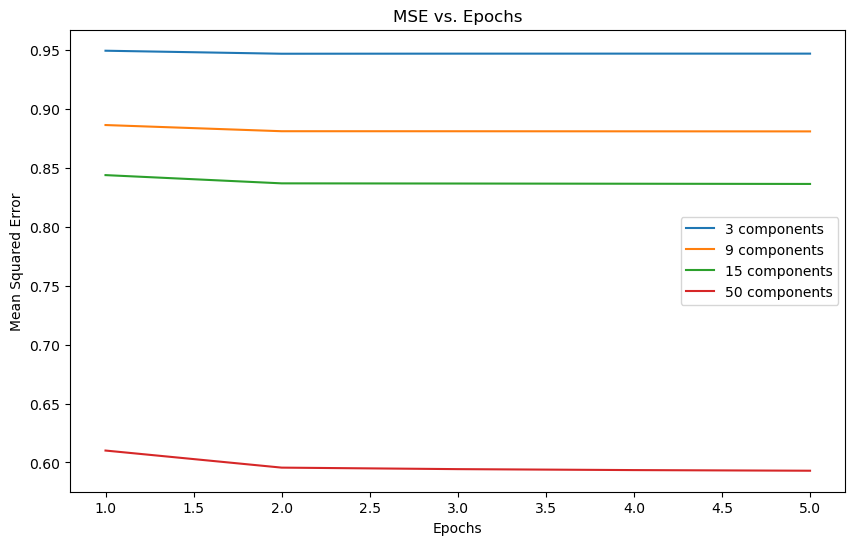

In [32]:
# Run this code to visualize the error, how can you explain the following plot?
# Write your explanation in a cell below this code.

epochs = [i for i in range(1,6)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, history_data[3]['loss'], label='3 components')
plt.plot(epochs, history_data[9]['loss'], label='9 components')
plt.plot(epochs, history_data[15]['loss'], label='15 components')
plt.plot(epochs, history_data[50]['loss'], label='50 components')
plt.title('MSE vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

**Explanation**: Considering there are 148 initial features, choosing only 3 principal components to make predictions probably isn't sufficient. It appears as though the more components we add, the more accurately we are able to predict weekly sales. Adding more components captures a larger portion of the variance in the data, allowing the model to utilize more relevant information effectively, which can help make better predictions (in this case, without introducing too much noise).

In [39]:
desired_num_of_components = 50

X_train_PC_codings = encoders[desired_num_of_components].predict(x_train_norm)

X_test_PC_codings = encoders[desired_num_of_components].predict(x_test_norm)

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 919us/step
3970/3970 ━━━━━━━━━━━━━━━━━━━━ 4s 992us/step


## Question 2: Tweaking the Parameters and Model for a Single Layer Perceptron

Using the best principal components (codings) from above as the features for the following linear regression model, testing three different optimizers.

In [40]:
# This describes what the model consists of

lin_reg = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_PC_codings.shape[1],)),
    tf.keras.layers.Normalization(axis=-1), # When -1 the last axis of the input is assumed to be a feature dimension and is normalized per index.
    tf.keras.layers.Dense(1, activation='linear')
  ])

**Stochastic Gradient Descent**:

A little about SGD:  
- Addresses computational inefficiency of traditional gradient descent methods.  
- Only a single random training example (small batch) selected to calculate the gradient $\rightarrow$ introduces randomness (hence the stochastic).  
- Uses a constant learning rate; can be bad.  
- Usually noisier than typical gradient descent, but reaches minimum in similar time and much more computationally efficient.    

In [41]:
lin_reg.compile(loss="mse",optimizer="SGD", metrics=[tf.keras.metrics.Accuracy()])

In [42]:
X_train_PC_codings.shape

(293259, 50)

In [43]:
lin_reg.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 50)             │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152 (612.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 101 (408.00 B)

In [44]:
%%time
# This is built-in training loop
# It iterates over the training data in mini-batches (of some size, say 32 samples) for some number of epochs (an iteration over the entire training data)
# For each batch, the model will compute the gradient of the loss with regard to the weights (which uses the Backpropagation algorithm)
# It then moves the weights in the direction that will reduce the value of the loss for this batch of data


sgd_history = lin_reg.fit(X_train_PC_codings, y_train_norm, epochs=5, verbose=True, batch_size = 32)

Epoch 1/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.0000e+00 - loss: 1.0092
Epoch 2/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.0000e+00 - loss: 0.9685
Epoch 3/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9685
Epoch 4/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.0000e+00 - loss: 0.9683
Epoch 5/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9684
CPU times: total: 28.5 s
Wall time: 1min 8s


In [45]:
# Returns the loss value & metrics values for the model

lin_reg.evaluate(lin_reg.predict(X_train_PC_codings), y_train_norm)

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 984us/step
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0000e+00 - loss: 1.0800


[1.1254403591156006, 0.0]

**RMSProp**:

A little about RMSProp:  
- Utilizes **moving average** of the squared gradients to scale the learning rate for each parameter $\rightarrow$ prevents oscillations in the optimization trajectory by maintaining a blaance between efficient convergence and stability during the training process.  

Advantages:  
- Fast convergence  
- Stable learning  
- Fewer hyperparameters  
- Good performance on non-convex problems

Compiling with RMSProp optimizer along with accuracy metrics:

In [46]:
lin_reg.compile(loss="mse",optimizer="RMSProp", metrics = [tf.keras.metrics.Accuracy()])


In [47]:
rms_history = lin_reg.fit(X_train_PC_codings, y_train_norm, epochs=5, verbose=True, batch_size=32)

Epoch 1/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9264
Epoch 2/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9251
Epoch 3/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9251
Epoch 4/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.0000e+00 - loss: 0.9250
Epoch 5/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9251


In [48]:
lin_reg.evaluate(lin_reg.predict(X_train_PC_codings), y_train_norm)

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.0000e+00 - loss: 1.0404


[1.0863676071166992, 0.0]

Looks like RMSProp has slightly less loss than SGD, but still performs pretty poorly. 

**Adam:**

A little about Adam:  
- Combo of gradient descent with momentum and RMSProp.  
- Momentum used to accelerate the gradient descent algorithms by taking into consideration the exponentially weighted average of the gradients $\rightarrow$ converge towards minima faster.  

**Momentum:**  
$w_{t+1} = w_t - \alpha m_t$, where  

$m_t = \beta m_{t-1} + (1 - \beta) [\frac{\delta L}{\delta w_t}]$.  

$m_t$: aggregate of gradients at time t [current] (initially, $m_t$ = 0)  
$m_{t-1}$: aggregate of gradients at time t-1 [previous]  
$w_t$: weights at time $t$  
$w_{t+1}$: weights at time $t+1$  
$\alpha _t$: learning rate at time $t$  
$\delta L$: derivative of loss function  
$\delta w_t$: derivative of weight at time $t$  
$\beta$: moving average parameter (const, 0.9)  

**RMSProp**:  
$w_{t+1} = w_t - \frac{\alpha _t}{(v_t + \epsilon)^{1/2}} \cdot [\frac{\delta L}{\delta w_t}]$, where  

$v_t = \beta v_{t-1} + (1 - \beta) \cdot [\frac{\delta L}{\delta w_t}]^2$  

w_t$: weights at time $t$  
$w_{t+1}$: weights at time $t+1$  
$\alpha _t$: learning rate at time $t$  
$\delta L$: derivative of loss function  
$\delta w_t$: derivative of weight at time $t$  
$v_t$: sum of square of past gradients. Initially, $v_t$ = 0.  
$\beta$: moving average parameter (const, 0.9)  
$\epsilon$: small positive constant $(10^{-8})$  

**Adam:**  
$m_t = \beta _1 m_{t-1} + (1 - \beta _1) [\frac{\delta L}{\delta w_t}]$  
$v_t = \beta _2 v_{t-1} + (1 - \beta _2) [\frac{\delta L}{\delta w_t}]^2$  

Parameters:  
1. $\epsilon$ = a small +ve constant to avoid 'division by 0' error when ($v_t \rightarrow 0$).  
2. $\beta _1$ and $\beta _2$ = decay rates of average of gradients in the above two methods. ($\beta _1$ = 0.9 & $\beta _2$ = 0.999).  
3. $\alpha$ - step size parameter/learning rate (0.001).

In [49]:
lin_reg.compile(loss="mse",optimizer="adam", metrics = [tf.keras.metrics.Accuracy()])


In [50]:
adam_history = lin_reg.fit(X_train_PC_codings, y_train_norm, epochs=5, verbose=True, batch_size=32)

Epoch 1/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9253
Epoch 2/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 961us/step - accuracy: 0.0000e+00 - loss: 0.9254
Epoch 3/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9253 
Epoch 4/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9253
Epoch 5/5
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0000e+00 - loss: 0.9252


In [51]:
lin_reg.evaluate(lin_reg.predict(X_train_PC_codings), y_train_norm)

9165/9165 ━━━━━━━━━━━━━━━━━━━━ 8s 905us/step
9165/9165 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.0000e+00 - loss: 1.0369


[1.0827391147613525, 0.0]

Slightly less loss than RMSProp!

**Plotting the histories**:

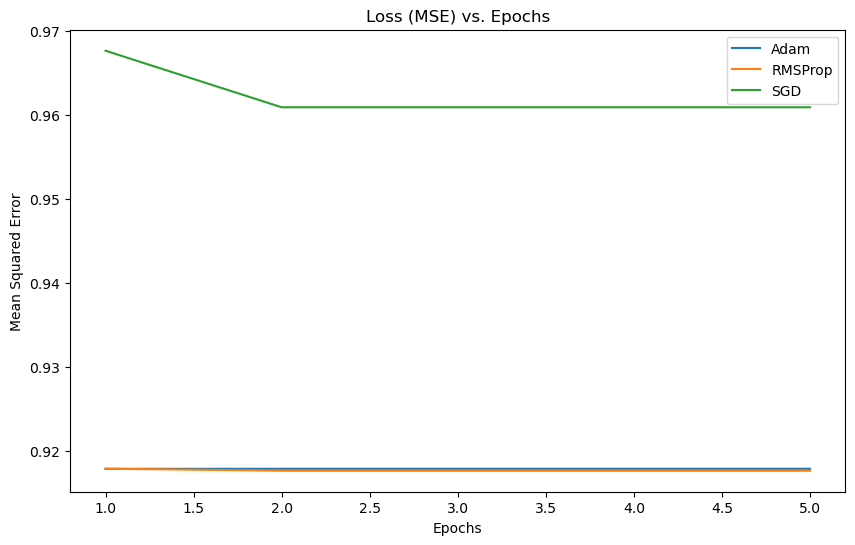

In [56]:
epochs = [i for i in range(1,6)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, adam_history.history['loss'], label='Adam')
plt.plot(epochs, rms_history.history['loss'], label='RMSProp')
plt.plot(epochs, sgd_history.history['loss'], label='SGD')
plt.title('Loss (MSE) vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

**Zooming in on the lower 2:**

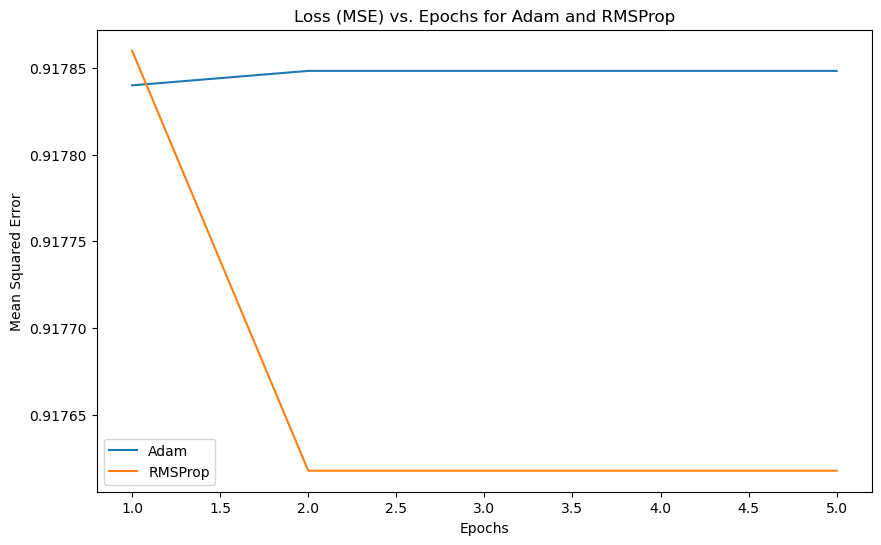

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, adam_history.history['loss'], label='Adam')
plt.plot(epochs, rms_history.history['loss'], label='RMSProp')
plt.title('Loss (MSE) vs. Epochs for Adam and RMSProp')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Looks like RMSProp performed the best on this problem!

## Question 3:  Implementing Mini-Batch SGD in a Training Loop for a Single-Layer Perceptron

In [58]:
# Lets first create some synthetic data for a simple regression problem

# Creating a synthetic dataset
np.random.seed(0)
data_size = 1000
x_data = np.random.rand(data_size, 1).astype(np.float32)

# y = 2x + 1 + noise
y_data = 2 * x_data + 1 + 0.2 * np.random.randn(data_size, 1).astype(np.float32)

In [88]:
import math
# Training
learning_rate = 0.01
epochs = 100
batch_size = 16

# The number of steps/number of batches is equal to the number of samples divided by the batch size. I take the ceil() to ensure that we don't miss the data at the end.
num_steps = math.ceil(x_data.shape[0] / batch_size) 
print(num_steps)


63


In [87]:
loss_history = []
# Initializing w and b with TF Variable objects:
w = tf.Variable(3.0, tf.float32)
b = tf.Variable(-1.0, tf.float32)

w_history = []
b_history = []

w_gradient_history = []
b_gradient_history = []

w_history.append(w.numpy())
b_history.append(b.numpy())

# Training loop
for epoch in range(1, epochs):
    print(epoch,end='\r')
    for i in range(0, num_steps): # Want to compute on each batch of data until the end, with no overlap (so use num_steps)

        x_slice = x_data[batch_size * i: batch_size * (i + 1)]
        y_slice = y_data[batch_size * i: batch_size * (i + 1)]

        ###################################### - complete the code to fill gradient tape that is used to compute gradients
        with tf.GradientTape() as tape:
          # y_pred is just the current w value * data batch + bias
          y_pred = w*x_slice + b
          # we use MSE loss:
          loss = tf.reduce_mean(tf.square(y_slice - y_pred))
          gradients = tape.gradient(loss, [w, b])

        w_gradient_history.append(gradients[0].numpy())
        b_gradient_history.append(gradients[1].numpy())

        ##################################### - complete the code to update the weights and bias
        # w_new = w_old - LR * gradient_w:
        w.assign_sub(learning_rate * gradients[0])

        # b_new = b_old - LR * gradient_b:
        b.assign_sub(learning_rate * gradients[1])
        #####################################

        w_history.append(w.numpy())
        b_history.append(b.numpy())

# Print trained parameters
print(f"Trained parameters: w = {w.numpy()}, b = {b.numpy()}")

Trained parameters: w = 1.9796149730682373, b = 1.0149080753326416


Text(0.5, 1.0, 'Gradient of w over history')

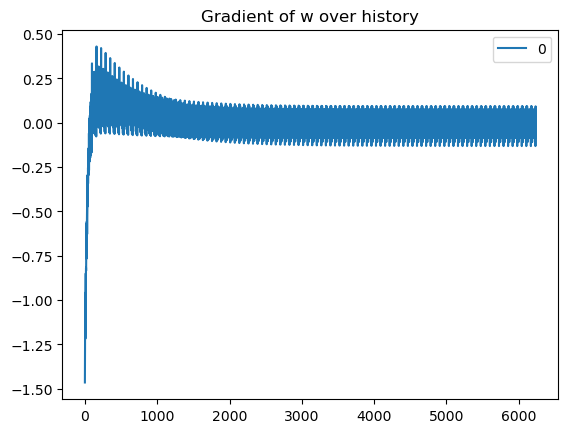

In [89]:
pd.DataFrame(w_gradient_history).plot()
plt.title('Gradient of w over history')

Text(0.5, 1.0, 'Weight (w) value over history')

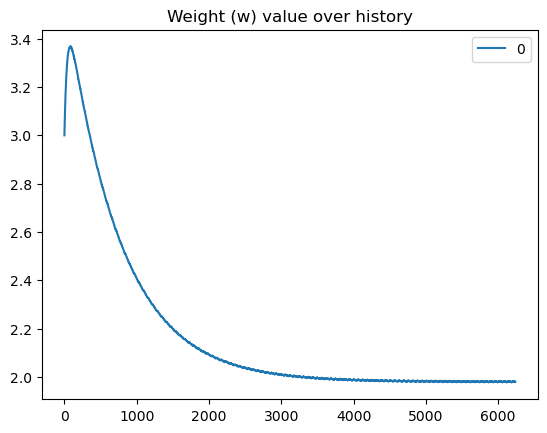

In [90]:
pd.DataFrame(w_history).plot()
plt.title('Weight (w) value over history')

Text(0.5, 1.0, 'Bias (b) history')

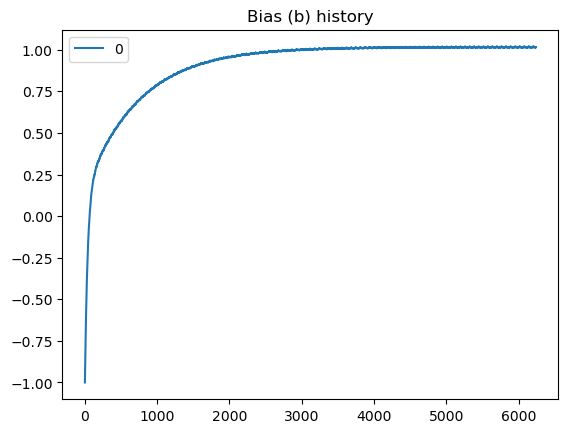

In [91]:
pd.DataFrame(b_history).plot()
plt.title('Bias (b) history')